# 2. Advanced Tutorials - 3. Image Generation - 2. GANs - 1. DCGAN
# 2. DCGAN
1. What are GANs?
 - Import Tensorflow and other libraries
 - Load and prepare the dataset
- Create the models
 - The Generator
 - The Discriminator
- Define the loss and optimizers
 - Discriminator loss
 - Generator loss
 - Save checkpoints
- Define the training loop
- Train the model
- Create a GIF
- Next steps

URL : https://www.tensorflow.org/alpha/tutorials/generative/dcgan#top_of_page<br>
GitHub : https://github.com/tensorflow/docs/blob/master/site/en/r2/tutorials/generative/dcgan.ipynb<br>
Colab : https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/r2/tutorials/generative/dcgan.ipynb

DCGAN : https://arxiv.org/pdf/1511.06434.pdf<br>
Keras Sequential API : https://www.tensorflow.org/guide/keras

## 1. What are GANs?
###  Import Tensorflow and other libraries

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

In [2]:
import tensorflow as tf
tf.__version__

'2.0.0-alpha0'

In [3]:
! pip install -q imageio
# To generate GIFs

In [4]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

### Load and prepare the dataset

In [5]:
(train_images, train_labels),(_,_) = tf.keras.datasets.mnist.load_data()

In [6]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5  # Normalize the images to [-1,1]

In [26]:
train_images.shape

(60000, 28, 28, 1)

In [7]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [8]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## 2. Create the models
### The Generator
The generator uses tf.keras.layers.Conv2DTranspose (upsampling) layers to produce an image from a seed (random noise). 

Start with a Dense layer that takes this seed as input, then upsample several times until you reach the desired image size of 28x28x1. 

Notice the tf.keras.layers.LeakyReLU activation for each layer, except the output layer which uses tanh.

In [9]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Reshape((7,7,256)))
    assert model.output_shape == (None, 7, 7, 256)
    
    model.add(layers.Conv2DTranspose(128, (5,5), strides=(1,1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(64, (5,5), strides=(2,2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(1, (5,5), strides=(2,2), padding='same', use_bias=False))
    assert model.output_shape == (None, 28, 28, 1)
    
    return model

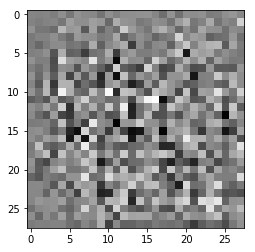

In [10]:
generator = make_generator_model()

noise = tf.random.normal([1,100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

### The Discriminator

In [11]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5,5), strides=(2,2), padding='same', input_shape=[28,28,1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Conv2D(128, (5,5), strides=(2,2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Flatten())
    model.add(layers.Dense(1))
    
    return model

In [12]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print(decision)

tf.Tensor([[-0.00315557]], shape=(1, 1), dtype=float32)


## 3. Define the loss and optimizers

In [13]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

### Discriminator loss

In [14]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

### Generator loss

In [15]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output),fake_output)

In [16]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

### Save checkpoints

In [17]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir,'ckpt')
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                discriminator_optimizer=discriminator_optimizer,
                                generator=generator,
                                discriminator=discriminator)

## 4. Define the training loop

In [18]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [19]:
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim]) # 256,100
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)
        
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss , discriminator.trainable_variables)
    
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    

In [20]:
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)
    
    fig = plt.figure(figsize=(4,4))
    
    for i in range(predictions.shape[0]):
        plt.subplot(4,4,i+1)
        plt.imshow(predictions[i, :, :, 0]*127.5 + 127.5, cmap='gray')
        plt.axis('off')
        
    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

In [21]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()
        
        for image_batch in dataset:
            train_step(image_batch)
            
        display.clear_output(wait=True)
        generate_and_save_images(generator,
                                epoch+1,
                                seed)
        
        if (epoch+1) % 15 ==0:
            checkpoint.save(file_prefix= checkpoint_prefix)
            
        print('Time for epoch {} is {} sec'.format(epoch+1, time.time() - start))
        
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                            epochs,
                            seed)

## 5. Train the model

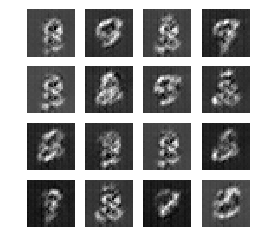

Time for epoch 14 is 23.02840495109558 sec


KeyboardInterrupt: 

In [22]:
%%time
train(train_dataset, EPOCHS)

In [23]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

## 6. Create a GIF

In [24]:
def display_image(epoch_no):
    return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

In [25]:
display_image(EPOCHS)

FileNotFoundError: [Errno 2] No such file or directory: 'image_at_epoch_0050.png'

In [ ]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('image*.png')
    filenames = sorted(filenames)
    last = -1
    for i,filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)
    
import IPython
if IPython.version_info > (6, 2, 0, ''):
    display.Image(filename=anim_file)
        

In [ ]:
try:
    from google.colab import files
except ImportError:
    pass
else:
    files.download(lite_model_path)

## 7. Next steps

As a next step, you might like to experiment with a different dataset, for example the Large-scale Celeb Faces Attributes (CelebA) dataset available on Kaggle. <br>
https://www.kaggle.com/jessicali9530/celeba-dataset/home<br>

To learn more about GANs we recommend the NIPS 2016 Tutorial: Generative Adversarial Networks.<br>
https://arxiv.org/abs/1701.00160